In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Aesthetic settings for plots
plt.style.use('ggplot')
sns.set()
%matplotlib inline

print("Libraries successfully loaded")


Libraries successfully loaded


In [2]:
# Load datasets
df_app = pd.read_csv('application_record.csv')
df_credit = pd.read_csv('credit_record.csv')

# Preview first rows of each dataset 
print("Application Record")
print(df_app.head())
print("\nCredit Record")
print(df_credit.head())


Application Record
        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apa

In [3]:
# Display dataset dimensions
print("application_record shape:", df_app.shape)
print("credit_record shape:", df_credit.shape)

print("\nGeneral information of application_record:")
print(df_app.info())

print("\nGeneral information of credit_record:")
print(df_credit.info())


application_record shape: (438557, 18)
credit_record shape: (1048575, 3)

General information of application_record:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FL

In [4]:
# Extract the worst credit status (maximum delay) for each client
df_status = df_credit.groupby('ID')['STATUS'].apply(lambda x: x.replace('C', '0').replace('X', '0').astype(int).max())

# Reset index and rename column
df_status = df_status.reset_index()
df_status.rename(columns={'STATUS': 'max_status'}, inplace=True)

# Merge with application data on client ID
df_final = df_app.merge(df_status, on='ID', how='inner')

# Output the shape after merging
print("Shape after merging:", df_final.shape)
# Preview merged dataset
df_final.head()


Shape after merging: (36457, 19)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,max_status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [5]:
# Step 1: Create binary target variable (risk label) ===
# Label as '1' if the customer ever had a delay >= 3 months (high risk)
df_final['risk_label'] = np.where(df_final['max_status'] >= 3, 1, 0)

# Step 2: Create derived features
# Convert age from days to years
df_final['edad'] = -df_final['DAYS_BIRTH'] // 365
# Convert employment duration to years (ignore anomalies like 365243)
df_final['antiguedad_laboral'] = df_final['DAYS_EMPLOYED'].apply(lambda x: -x//365 if x < 0 else 0)

# Display class balance
print(df_final['risk_label'].value_counts())
print("Proportion of high-risk clients:", df_final['risk_label'].mean())


risk_label
0    36155
1      302
Name: count, dtype: int64
Proportion of high-risk clients: 0.008283731519324135


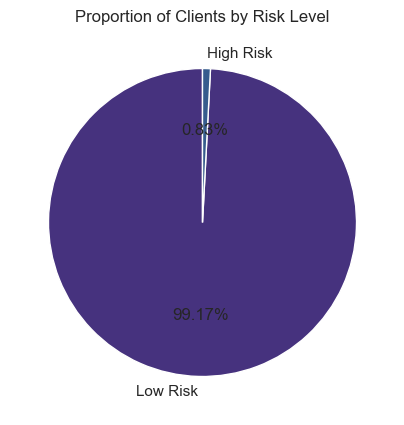

In [6]:
# Class proportions (normalized)
proportions = df_final['risk_label'].value_counts(normalize=True)

# Pie chart
plt.figure(figsize=(5,5))
plt.pie(proportions.values, labels=['Low Risk', 'High Risk'], autopct='%1.2f%%', colors=sns.color_palette('viridis'), startangle=90)
plt.title('Proportion of Clients by Risk Level')
plt.show()


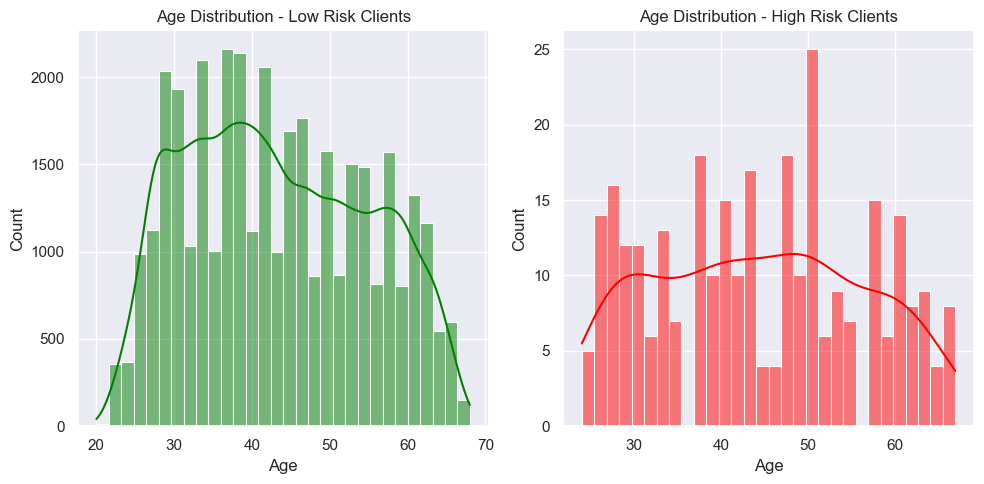

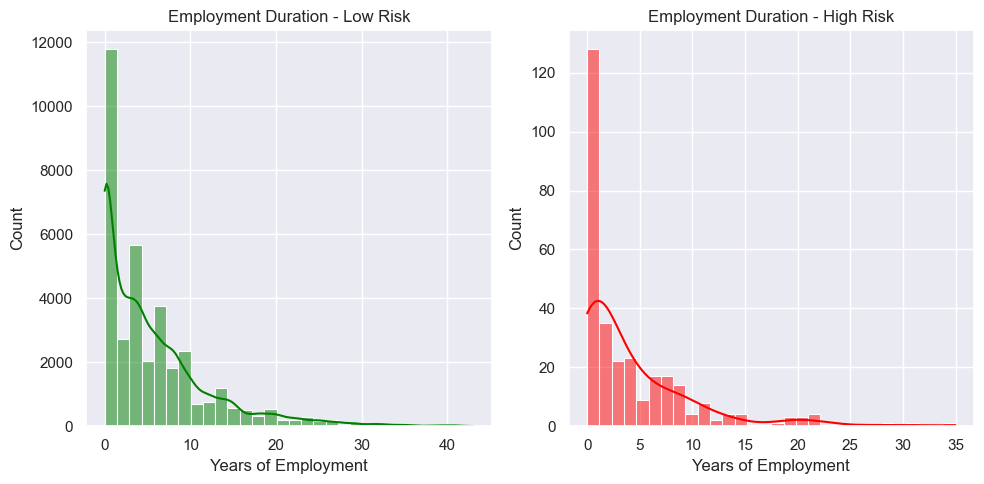

In [7]:
# Compare age distributions by risk label
plt.figure(figsize=(10,5))

# Low-risk clients
plt.subplot(1,2,1)
sns.histplot(df_final[df_final['risk_label'] == 0]['edad'], bins=30, kde=True, color='green')
plt.title('Age Distribution - Low Risk Clients')
plt.xlabel('Age')

# High-risk clients
plt.subplot(1,2,2)
sns.histplot(df_final[df_final['risk_label'] == 1]['edad'], bins=30, kde=True, color='red')
plt.title('Age Distribution - High Risk Clients')
plt.xlabel('Age')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

# Low-risk clients
plt.subplot(1,2,1)
sns.histplot(df_final[df_final['risk_label'] == 0]['antiguedad_laboral'], bins=30, kde=True, color='green')
plt.title('Employment Duration - Low Risk')
plt.xlabel('Years of Employment')

# High-risk clients
plt.subplot(1,2,2)
sns.histplot(df_final[df_final['risk_label'] == 1]['antiguedad_laboral'], bins=30, kde=True, color='red')
plt.title('Employment Duration - High Risk')
plt.xlabel('Years of Employment')

plt.tight_layout()
plt.show()



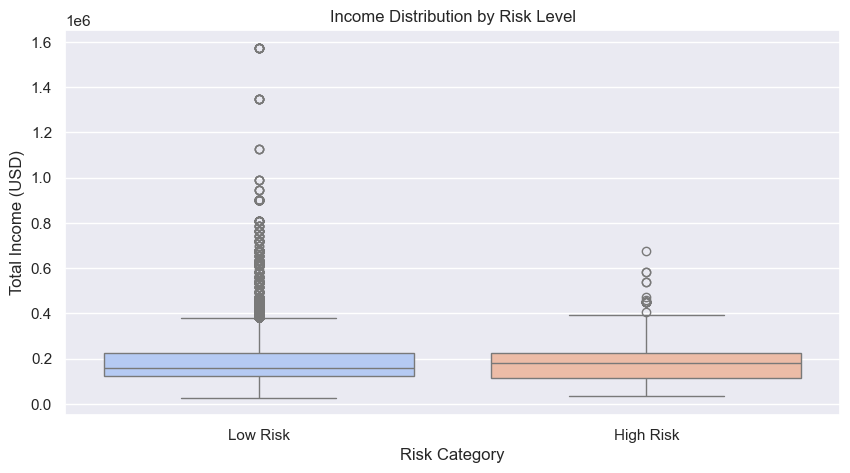

In [8]:
# Boxplot: Income distribution by credit risk level
plt.figure(figsize=(10,5))
sns.boxplot(data=df_final, x='risk_label', y='AMT_INCOME_TOTAL', hue='risk_label', palette='coolwarm', legend=False)
plt.title('Income Distribution by Risk Level')
plt.xticks([0,1], ['Low Risk', 'High Risk'])
plt.xlabel('Risk Category')
plt.ylabel('Total Income (USD)')
plt.show()



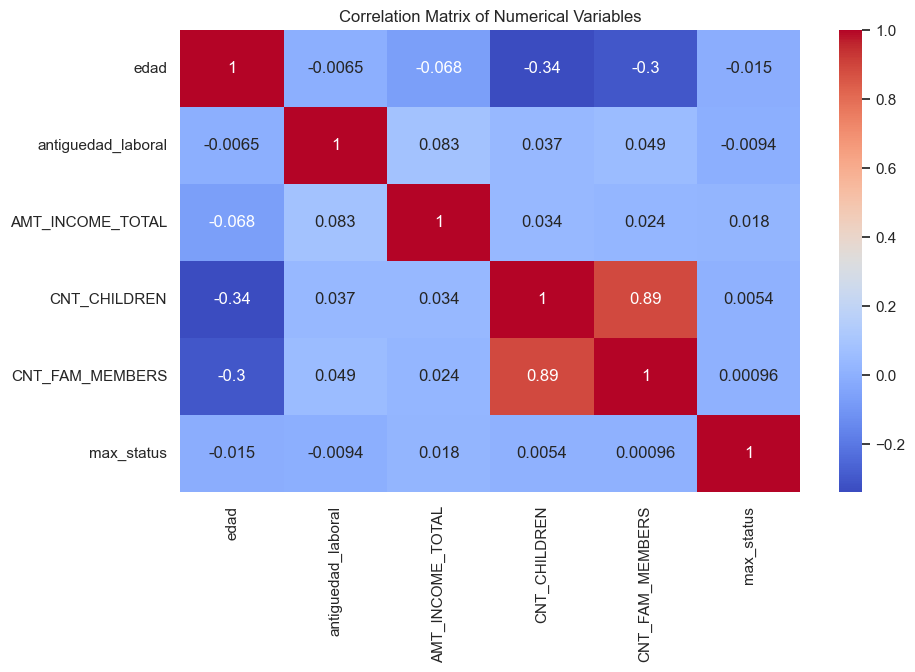

In [9]:
# Correlation matrix of selected numerical variables
plt.figure(figsize=(10, 6))

corr = df_final[[
    'edad',
    'antiguedad_laboral',
    'AMT_INCOME_TOTAL',
    'CNT_CHILDREN',
    'CNT_FAM_MEMBERS',
    'max_status'
]].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Variables")
plt.show()


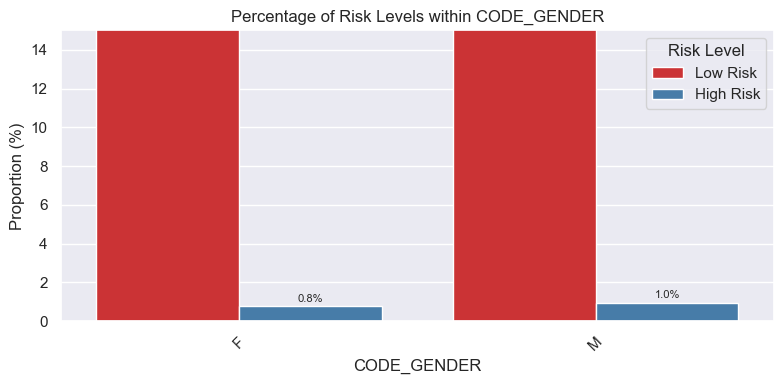

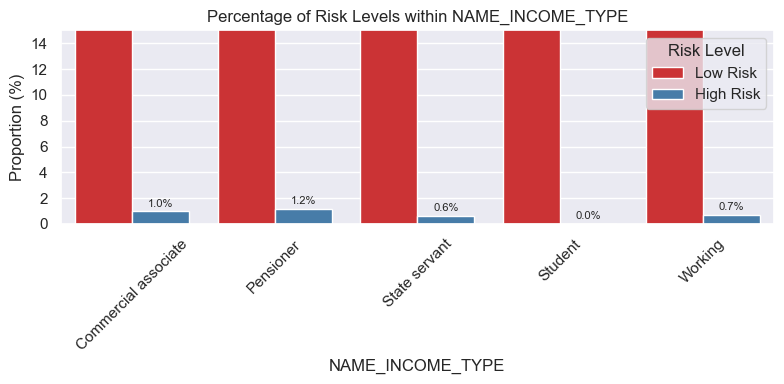

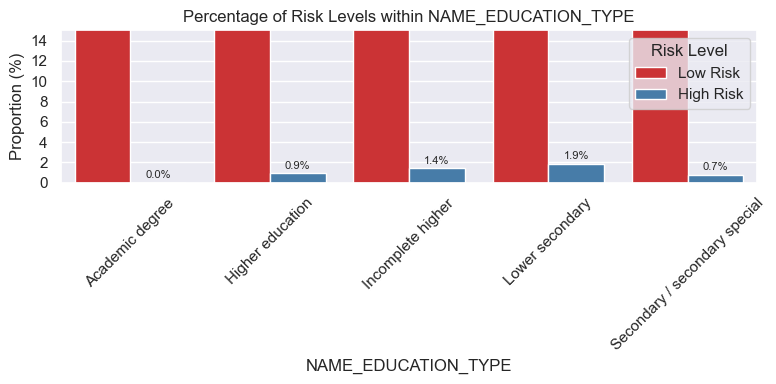

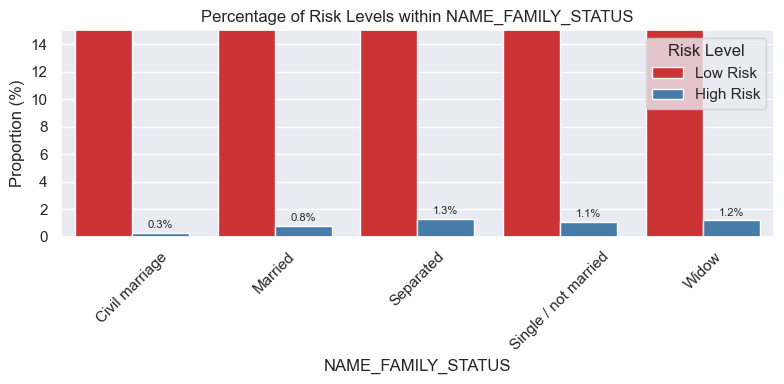

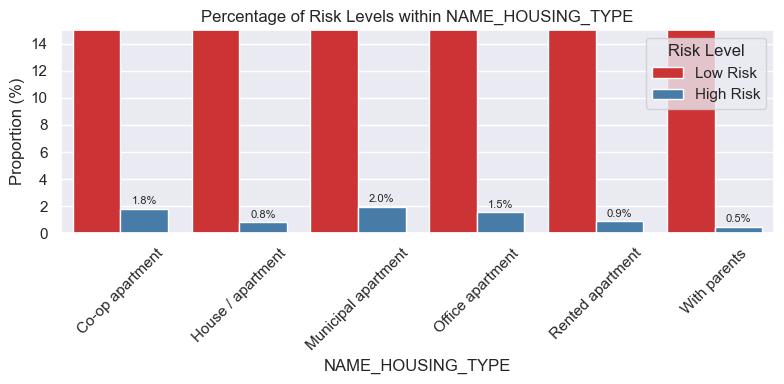

In [10]:
# Key categorical variables to analyze ===
categorical_vars = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

# Plot proportion of risk within each category ===
for var in categorical_vars:
    # Calculate proportion of risk classes within each category
    prop_df = pd.crosstab(df_final[var], df_final['risk_label'], normalize='index').reset_index()
    prop_df.columns.name = None
    prop_df.rename(columns={0: 'Low Risk', 1: 'High Risk'}, inplace=True)

    # Melt for plotting
    prop_df_melt = prop_df.melt(
        id_vars=var,
        value_vars=['Low Risk', 'High Risk'],
        var_name='Risk Level',
        value_name='Proportion'
    )
    prop_df_melt['Proportion'] *= 100  # Convert to percentage

    # Plot grouped bar chart
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        data=prop_df_melt,
        x=var,
        y='Proportion',
        hue='Risk Level',
        palette='Set1'
    )
    plt.title(f'Percentage of Risk Levels within {var}')
    plt.ylabel('Proportion (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 15)
    plt.yticks(np.arange(0, 16, 2))

    # Annotate bars with percentage labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=8, padding=2)

    plt.tight_layout()
    plt.show()


In [11]:
# Create derived features

# Age in years
df_final['age'] = -df_final['DAYS_BIRTH'] // 365

# Employment duration in years (treat anomalies like 365243 as 0)
df_final['employment_years'] = df_final['DAYS_EMPLOYED'].apply(lambda x: -x // 365 if x < 0 else 0)

# Income per family member ratio
df_final['income_per_family_member'] = df_final['AMT_INCOME_TOTAL'] / (df_final['CNT_FAM_MEMBERS'] + 1)

# Display derived features alongside ID and target label
print(df_final[['ID', 'age', 'employment_years', 'income_per_family_member', 'risk_label']].head(10))

# Summary statistics of new features
print("\nStatistical summary of derived features:")
print(df_final[['age', 'employment_years', 'income_per_family_member']].describe())


        ID  age  employment_years  income_per_family_member  risk_label
0  5008804   32                12                  142500.0           0
1  5008805   32                12                  142500.0           0
2  5008806   58                 3                   37500.0           0
3  5008808   52                 8                  135000.0           0
4  5008809   52                 8                  135000.0           0
5  5008810   52                 8                  135000.0           0
6  5008811   52                 8                  135000.0           0
7  5008812   61                 0                  141750.0           0
8  5008813   61                 0                  141750.0           0
9  5008814   61                 0                  141750.0           0

Statistical summary of derived features:
                age  employment_years  income_per_family_member
count  36457.000000      36457.000000              36457.000000
mean      43.260334          5.614560 

In [12]:
# Define columns to drop before modeling
cols_drop = ['ID', 'max_status', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'risk_label']  # Raw or target-related columns

# Define predictor variables (features)
X = df_final.drop(columns=cols_drop)

# Define target variable
y = df_final['risk_label']

# Display shapes of feature matrix and target vector
print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (36457, 20)
y shape: (36457,)


In [13]:
# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Display the shape after encoding
print("Shape after encoding:", X_encoded.shape)



Shape after encoding: (36457, 49)


In [14]:
from sklearn.preprocessing import StandardScaler

# Define numerical columns to scale
num_cols = [
    'AMT_INCOME_TOTAL',
    'CNT_CHILDREN',
    'CNT_FAM_MEMBERS',
    'age',
    'employment_years',
    'income_per_family_member'
]

# Apply scaling only to numerical columns
X_scaled = X_encoded.copy()
scaler = StandardScaler()
X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])

print("Scaling applied successfully.\n")

# Visual validation of scaling 
print("Mean of scaled features:")
print(X_scaled[num_cols].mean())

print("\nStandard deviation of scaled features:")
print(X_scaled[num_cols].std())


Scaling applied successfully.

Mean of scaled features:
AMT_INCOME_TOTAL            1.559191e-18
CNT_CHILDREN               -2.280317e-17
CNT_FAM_MEMBERS             2.424542e-16
age                        -3.118382e-18
employment_years            6.236763e-18
income_per_family_member    8.575549e-18
dtype: float64

Standard deviation of scaled features:
AMT_INCOME_TOTAL            1.000014
CNT_CHILDREN                1.000014
CNT_FAM_MEMBERS             1.000014
age                         1.000014
employment_years            1.000014
income_per_family_member    1.000014
dtype: float64


In [15]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (stratified by class)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,  # Ensures class proportions are preserved
    random_state=42
)

# Display class distribution in the training set
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))

# Display class distribution in the test set
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))



Class distribution in training set:
risk_label
0    0.991702
1    0.008298
Name: proportion, dtype: float64

Class distribution in test set:
risk_label
0    0.991772
1    0.008228
Name: proportion, dtype: float64


In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Display new class distribution after SMOTE
print("Class balance after SMOTE:")
print(y_train_bal.value_counts())



Class balance after SMOTE:
risk_label
0    28923
1    28923
Name: count, dtype: int64


=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0     0.9920    0.9479    0.9695      7232
           1     0.0131    0.0833    0.0226        60

    accuracy                         0.9408      7292
   macro avg     0.5026    0.5156    0.4960      7292
weighted avg     0.9840    0.9408    0.9617      7292



C:\Users\Daniel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


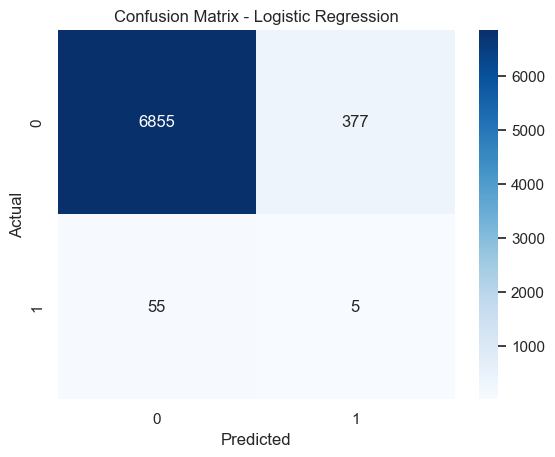

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train Logistic Regression model 
lr_model = LogisticRegression(max_iter=2000, solver='saga')  
lr_model.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Report
print("=== Logistic Regression Performance ===")
print(classification_report(y_test, y_pred_lr, digits=4))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




=== Random Forest Performance ===
              precision    recall  f1-score   support

           0     0.9934    0.9960    0.9947      7232
           1     0.2927    0.2000    0.2376        60

    accuracy                         0.9894      7292
   macro avg     0.6430    0.5980    0.6162      7292
weighted avg     0.9876    0.9894    0.9885      7292



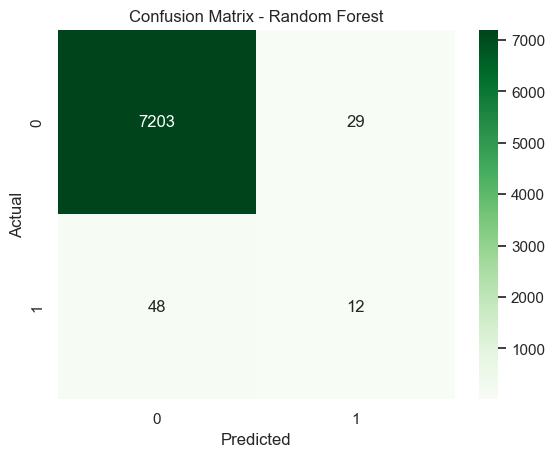

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Classification report
print("=== Random Forest Performance ===")
print(classification_report(y_test, y_pred_rf, digits=4))

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



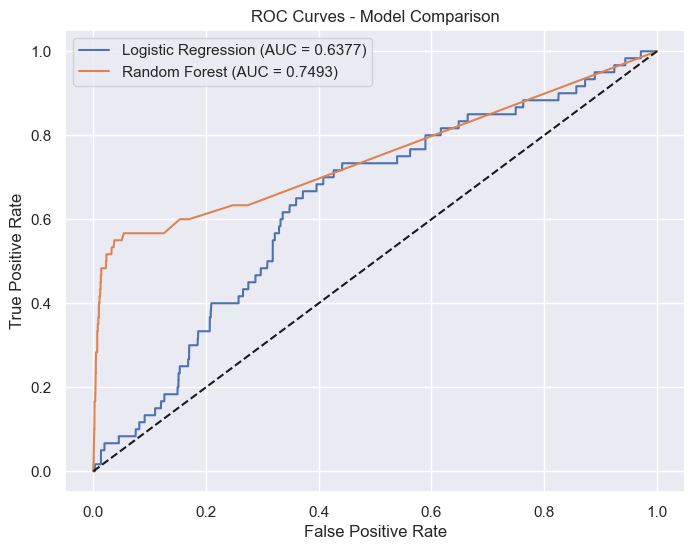

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities for the positive class
y_score_lr = lr_model.predict_proba(X_test)[:, 1]
y_score_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_score_lr):.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_score_rf):.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line as random baseline

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()



=== XGBoost Performance ===
              precision    recall  f1-score   support

           0     0.9958    0.8245    0.9021      7232
           1     0.0268    0.5833    0.0513        60

    accuracy                         0.8225      7292
   macro avg     0.5113    0.7039    0.4767      7292
weighted avg     0.9879    0.8225    0.8951      7292



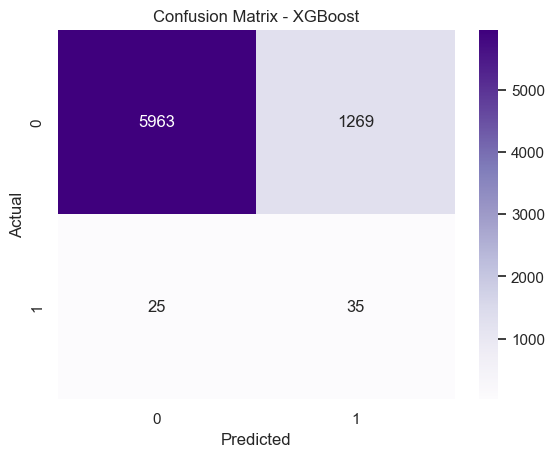

In [20]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train basic XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Handle class imbalance
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_bal, y_train_bal)

# Make predictions on the test set 
y_pred_xgb = xgb_model.predict(X_test)

# Classification report 
print("=== XGBoost Performance ===")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap='Purples')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid for XGBoost tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [
        (y_train == 0).sum() / (y_train == 1).sum()  # Handle class imbalance
    ]
}
# Base XGBoost classifier
xgb_clf = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)
# Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',  # Can be changed to 'roc_auc', 'recall', etc.
    cv=3,
    verbose=2,
    n_jobs=-1
)
# Perform grid search 
grid_search.fit(X_train_bal, y_train_bal)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)



Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': np.float64(119.51652892561984)}
Best cross-validated score: 0.9777733948531918


=== XGBoost (Tuned) Performance ===
              precision    recall  f1-score   support

           0     0.9957    0.9505    0.9726      7232
           1     0.0773    0.5000    0.1339        60

    accuracy                         0.9468      7292
   macro avg     0.5365    0.7252    0.5532      7292
weighted avg     0.9881    0.9468    0.9657      7292



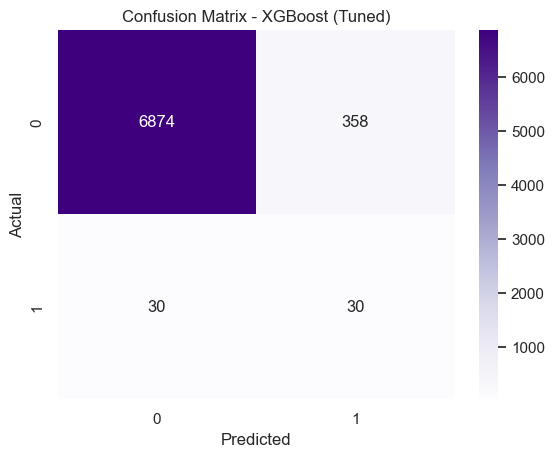

In [22]:
# Retrieve the best model from GridSearchCV 
best_xgb = grid_search.best_estimator_

# Retrain on the full balanced training set (no cross-validation this time)
best_xgb.fit(X_train_bal, y_train_bal)

# Make predictions on the test set 
y_pred_xgb_tuned = best_xgb.predict(X_test)

# Classification report
print("=== XGBoost (Tuned) Performance ===")
print(classification_report(y_test, y_pred_xgb_tuned, digits=4))

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_tuned), annot=True, fmt="d", cmap='Purples')
plt.title('Confusion Matrix - XGBoost (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [23]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define parameter distributions for randomized search
param_dist = {
    'n_estimators': [150, 200, 250],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1],
    'scale_pos_weight': [
        (y_train == 0).sum() / (y_train == 1).sum()  # Handle class imbalance
    ]
}

# Initialize base XGBoost classifier
xgb_clf_rs = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    tree_method='hist'  # Faster histogram-based algorithm
)

# Perform randomized search over 20 parameter combinations
random_search = RandomizedSearchCV(
    estimator=xgb_clf_rs,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit randomized search on the balanced training set
random_search.fit(X_train_bal, y_train_bal)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'gamma': [0, 1],
                                        'learning_rate': [0.03, 0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [150, 200, 250],
                                        'scale_pos_weight': [np.float64(119.51652892561984)]},
                   random_state=42, scoring='f1', verbose=2)

Best parameters found: {'scale_pos_weight': np.float64(119.51652892561984), 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1}
Best cross-validated F1 score: 0.9811683766716176
=== XGBoost Tuned (Randomized Search) Performance ===
              precision    recall  f1-score   support

           0     0.9954    0.9635    0.9792      7232
           1     0.0959    0.4667    0.1591        60

    accuracy                         0.9594      7292
   macro avg     0.5457    0.7151    0.5691      7292
weighted avg     0.9880    0.9594    0.9725      7292



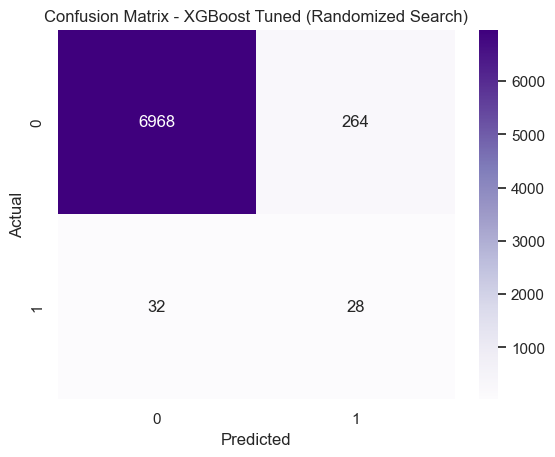

In [24]:
# Best hyperparameter combination found by Randomized Search
print("Best parameters found:", random_search.best_params_)
print("Best cross-validated F1 score:", random_search.best_score_)

# Train final model using the best combination
best_xgb_rs = random_search.best_estimator_
best_xgb_rs.fit(X_train_bal, y_train_bal)

# Final evaluation on the test set
y_pred_xgb_rs = best_xgb_rs.predict(X_test)

print("=== XGBoost Tuned (Randomized Search) Performance ===")
print(classification_report(y_test, y_pred_xgb_rs, digits=4))

# Confusion matrix heatmap 
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_rs), annot=True, fmt="d", cmap='Purples')
plt.title('Confusion Matrix - XGBoost Tuned (Randomized Search)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Starting hyperparameter search for Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best hyperparameters found:
{'n_estimators': 150, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 15}
Best cross-validated F1 score: 0.9882065271318762

Training Random Forest with best parameters...
Training completed.

=== Random Forest Tuned (Fast) Performance ===
              precision    recall  f1-score   support

           0     0.9935    0.9862    0.9898      7232
           1     0.1150    0.2167    0.1503        60

    accuracy                         0.9798      7292
   macro avg     0.5542    0.6014    0.5700      7292
weighted avg     0.9862    0.9798    0.9829      7292



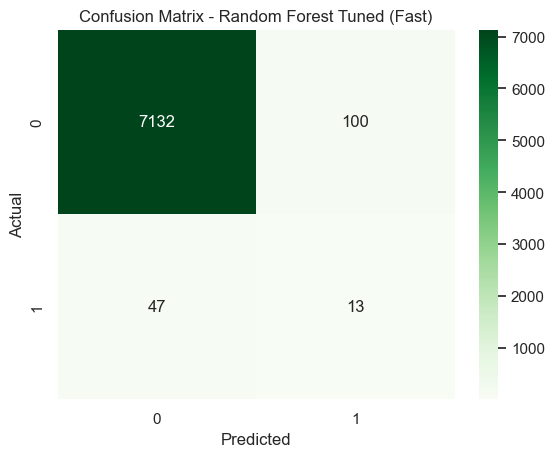

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define reduced hyperparameter grid for fast tuning
param_dist_rf_fast = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', None]
}

print("Starting hyperparameter search for Random Forest...")

# Set up RandomizedSearchCV with 3-fold cross-validation 
rf_clf_fast = RandomForestClassifier(random_state=42)

random_search_rf_fast = RandomizedSearchCV(
    estimator=rf_clf_fast,
    param_distributions=param_dist_rf_fast,
    n_iter=8,  # Evaluate only 8 random combinations
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Perform the randomized search
random_search_rf_fast.fit(X_train_bal, y_train_bal)

# Display best results 
print("\n✅ Best hyperparameters found:")
print(random_search_rf_fast.best_params_)
print("Best cross-validated F1 score:", random_search_rf_fast.best_score_)

# Train the final model with best parameters
print("\nTraining Random Forest with best parameters...")
best_rf_fast = random_search_rf_fast.best_estimator_
best_rf_fast.fit(X_train_bal, y_train_bal)
print("Training completed.")

# Evaluate on test set 
print("\n=== Random Forest Tuned (Fast) Performance ===")
y_pred_rf_tuned = best_rf_fast.predict(X_test)
print(classification_report(y_test, y_pred_rf_tuned, digits=4))

# Confusion matrix 
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuned), annot=True, fmt="d", cmap='Greens')
plt.title('Confusion Matrix - Random Forest Tuned (Fast)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


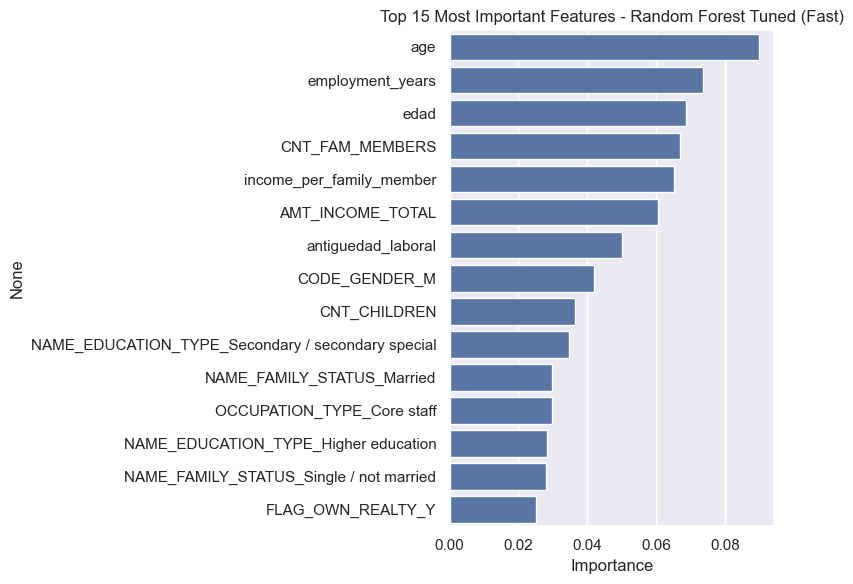

In [26]:
# Feature importance from the tuned Random Forest model 
importances = pd.Series(
    best_rf_fast.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(15)

# Plot top 15 most important features 
plt.figure(figsize=(8, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Top 15 Most Important Features - Random Forest Tuned (Fast)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()



In [27]:
import joblib

# Save the final tuned Random Forest model
joblib.dump(best_rf_fast, 'random_forest_tuned_fast.pkl')
print("Model exported as 'random_forest_tuned_fast.pkl'")



Model exported as 'random_forest_tuned_fast.pkl'


In [28]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Random Forest Tuned (Fast)
y_pred_rf = best_rf_fast.predict(X_test)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# XGBoost Tuned
y_pred_xgb = best_xgb.predict(X_test)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Create comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest (Fast)', 'XGBoost Tuned'],
    'Precision': [precision_lr, precision_rf, precision_xgb],
    'Recall': [recall_lr, recall_rf, recall_xgb],
    'F1-score': [f1_lr, f1_rf, f1_xgb]
})

print("\n=== Final Model Comparison ===")
print(results)




=== Final Model Comparison ===
                  Model  Precision    Recall  F1-score
0   Logistic Regression   0.013089  0.083333  0.022624
1  Random Forest (Fast)   0.115044  0.216667  0.150289
2         XGBoost Tuned   0.077320  0.500000  0.133929


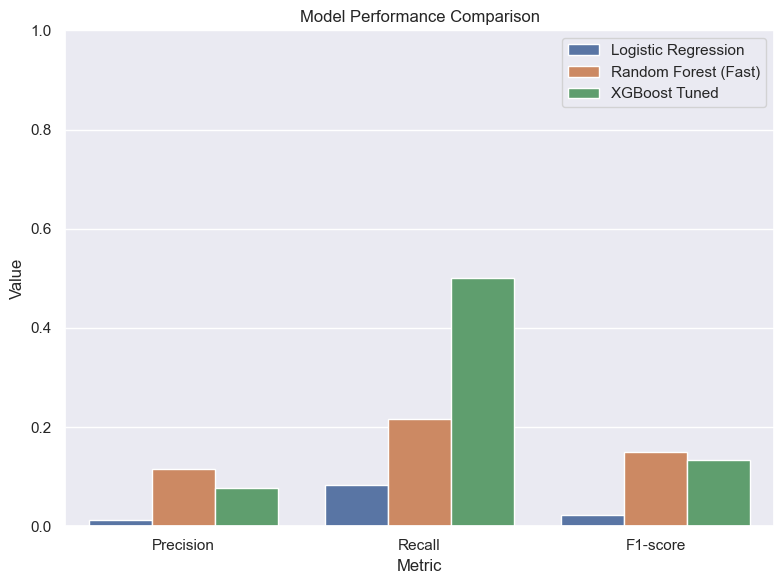

In [29]:
# Prepare data for visualization 
results_melted = results.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot comparison of model performance
plt.figure(figsize=(8, 6))
sns.barplot(data=results_melted, x='Metric', y='Value', hue='Model')

plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

